In [1]:

# # NFL Team Analysis
# 
# This notebook analyzes team-specific tendencies and performance metrics from the 2024 NFL play-by-play data.

# ## Setup and Data Loading

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add the parent directory to the path so we can import our scripts
sys.path.append('..')
from scripts.data_loader import load_pbp_data, get_team_colors, team_success_rate
from scripts.visualizations import plot_team_run_pass_ratio, plot_down_distance_heatmap

# Set plot style
plt.style.use('ggplot')
sns.set_palette('colorblind')
# matplotlib inline is only used in Jupyter notebooks

# Load the data
data_path = '../data/pbp-2024.csv'
df = load_pbp_data(data_path)
print(f"Loaded {len(df):,} plays from the 2024 NFL season")

# ## Team Rush vs Pass Tendencies

/var/folders/cq/dyx2ttcj47lckh2j68_y1qn80000gn/T/ipykernel_28250/3144532458.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Loaded 53,283 plays from the 2024 NFL season


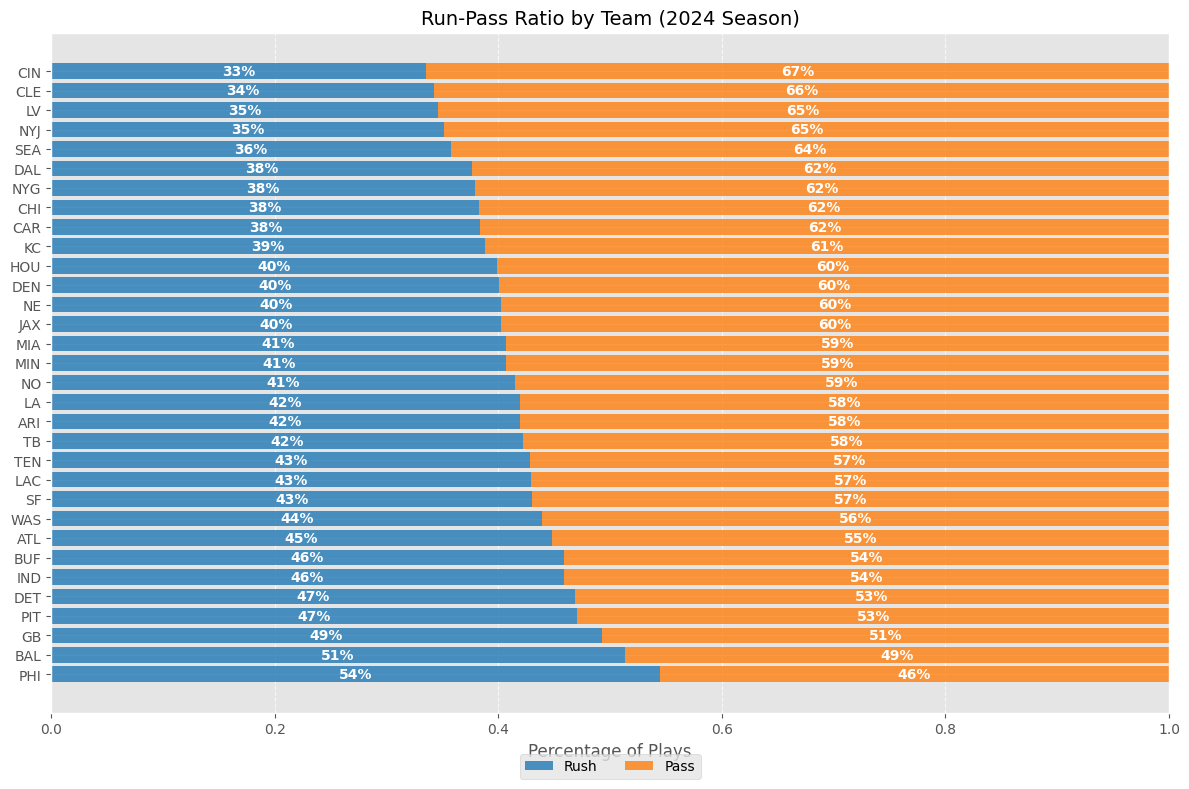

In [14]:

# Visualize rush vs pass ratio for all teams
run_pass_fig = plot_team_run_pass_ratio(df, top_n=32)
plt.tight_layout()
plt.show()

Pass play rate by team and down:
Down     1     2     3     4
Team                        
ARI   0.51  0.62  0.70  0.53
ATL   0.41  0.61  0.76  0.75
BAL   0.40  0.49  0.70  0.44
BUF   0.42  0.60  0.73  0.52
CAR   0.50  0.63  0.83  0.77
CHI   0.49  0.63  0.84  0.79
CIN   0.54  0.73  0.83  0.89
CLE   0.60  0.64  0.82  0.58
DAL   0.54  0.62  0.78  0.77
DEN   0.49  0.60  0.81  0.71
DET   0.46  0.55  0.71  0.55
GB    0.38  0.53  0.80  0.47
HOU   0.49  0.57  0.88  0.70
IND   0.45  0.57  0.67  0.64
JAX   0.46  0.68  0.78  0.44
KC    0.50  0.66  0.82  0.44
LA    0.52  0.57  0.74  0.56
LAC   0.44  0.66  0.69  0.69
LV    0.60  0.64  0.80  0.70
MIA   0.46  0.65  0.79  0.87
MIN   0.44  0.65  0.86  0.67
NE    0.47  0.63  0.83  0.62
NO    0.49  0.59  0.75  0.71
NYG   0.58  0.55  0.81  0.61
NYJ   0.54  0.67  0.86  0.76
PHI   0.33  0.53  0.61  0.52
PIT   0.41  0.54  0.79  0.35
SEA   0.57  0.64  0.82  0.44
SF    0.48  0.56  0.81  0.56
TB    0.49  0.59  0.80  0.38
TEN   0.45  0.62  0.76  0.78
WAS   0.44

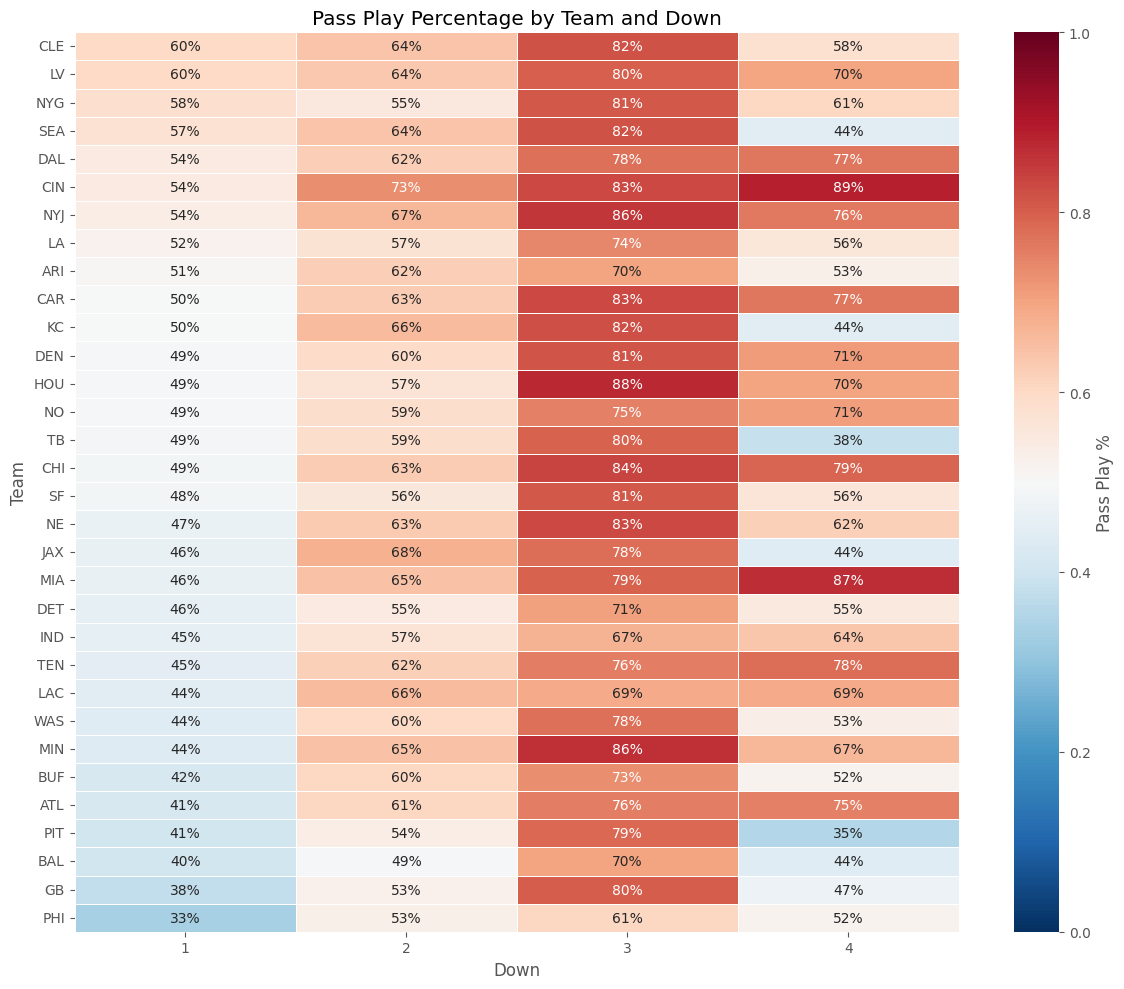

In [4]:

# Calculate and display run-pass ratio by down for each team
if all(col in df.columns for col in ['OffenseTeam', 'Down', 'PlayType']):
    # Filter for standard downs and play types
    play_df = df[
        (df['Down'].isin([1, 2, 3, 4])) & 
        (df['PlayType'].isin(['PASS', 'RUSH']))
    ]
    
    # Create pivot table
    team_down_plays = pd.pivot_table(
        play_df,
        index=['OffenseTeam', 'Down'],
        values='PlayType',
        aggfunc=lambda x: sum(x == 'PASS') / len(x),
        fill_value=0
    ).reset_index()
    
    team_down_plays.columns = ['Team', 'Down', 'Pass_Rate']
    team_down_plays['Rush_Rate'] = 1 - team_down_plays['Pass_Rate']
    
    # Reshape for better visualization
    team_down_pivot = team_down_plays.pivot(
        index='Team', 
        columns='Down', 
        values='Pass_Rate'
    )
    
    # Display the pivot table
    print("Pass play rate by team and down:")
    print(team_down_pivot.round(2))
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(team_down_pivot.sort_values(by=1, ascending=False), 
               cmap='RdBu_r', annot=True, fmt='.0%', linewidths=.5, vmin=0, vmax=1,
               cbar_kws={'label': 'Pass Play %'})
    plt.title('Pass Play Percentage by Team and Down')
    plt.tight_layout()
    plt.show()

# ## Team Success Rates

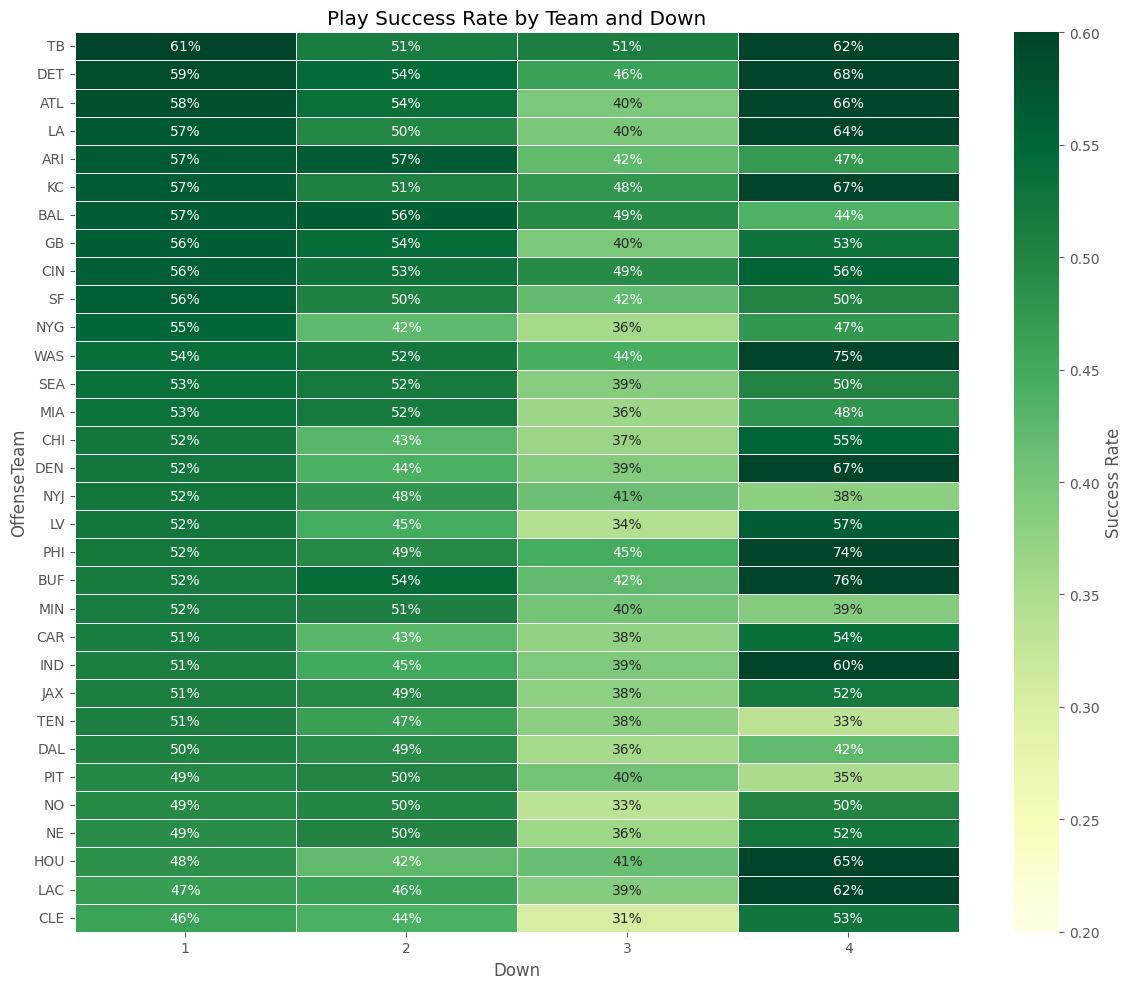

In [5]:

# Calculate success rates by team
success_rates = team_success_rate(df)

# Create pivot table for better visualization
success_pivot = success_rates.pivot(
    index='OffenseTeam',
    columns='Down',
    values='success_rate'
)

# Plot success rates
plt.figure(figsize=(12, 10))
sns.heatmap(success_pivot.sort_values(by=1, ascending=False), 
           cmap='YlGn', annot=True, fmt='.0%', linewidths=.5, vmin=0.2, vmax=0.6,
           cbar_kws={'label': 'Success Rate'})
plt.title('Play Success Rate by Team and Down')
plt.tight_layout()
plt.show()

# ## Team Play Calling by Field Position

/var/folders/cq/dyx2ttcj47lckh2j68_y1qn80000gn/T/ipykernel_28250/771409242.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pass_rate_by_pos = pd.pivot_table(


field_pos_group Own 0-20 Own 20-40 Own 40-Opp 40 Opp 40-20 Opp 20-0 (RZ)
count                 32        32            32        32            32
unique                 1         1             1         1             1
top                False     False         False     False         False
freq                  32        32            32        32            32


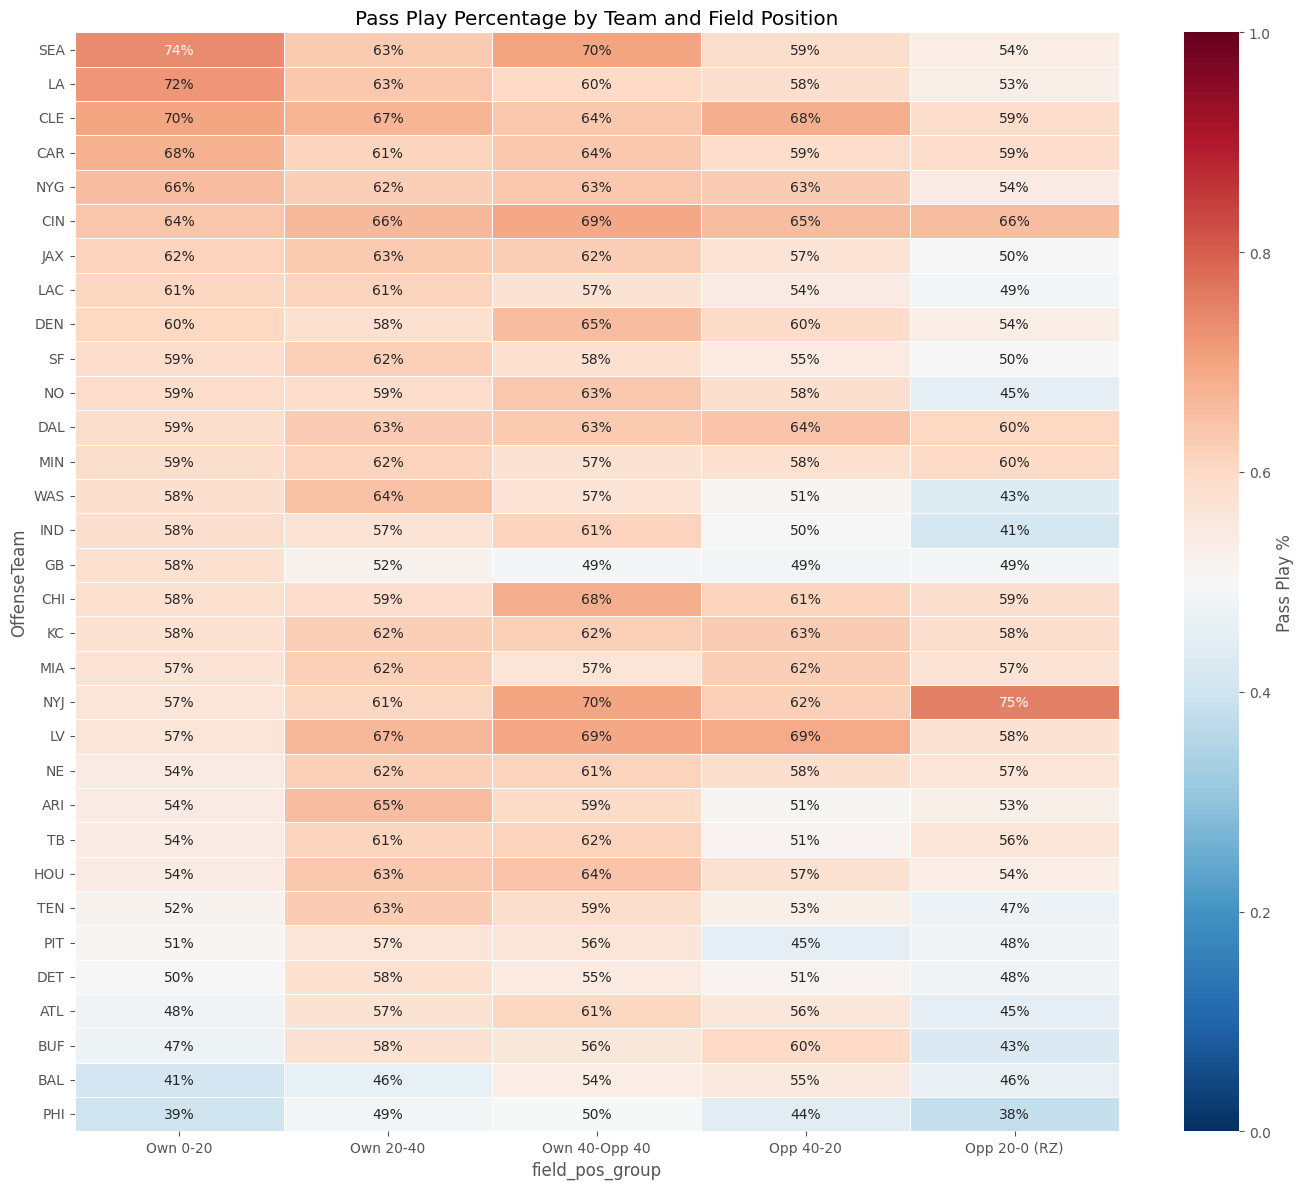

In [8]:

# Analyze how teams call plays based on field position
if all(col in df.columns for col in ['OffenseTeam', 'field_position', 'PlayType']):
    # Group field position into segments
    df['field_pos_group'] = pd.cut(
        df['field_position'],
        bins=[0, 20, 40, 60, 80, 100],
        labels=['Own 0-20', 'Own 20-40', 'Own 40-Opp 40', 'Opp 40-20', 'Opp 20-0 (RZ)']
    )
    
    # Calculate pass rate by team and field position
    field_pos_df = df[
        (df['PlayType'].isin(['PASS', 'RUSH'])) & 
        (~pd.isna(df['field_pos_group']))
    ]
    
    # Create pivot table
    pass_rate_by_pos = pd.pivot_table(
        field_pos_df,
        index='OffenseTeam',
        columns='field_pos_group',
        values='PlayType',
        aggfunc=lambda x: sum(x == 'PASS') / len(x) if len(x) > 0 else np.nan
    )
    
    # Sort the data first
    sorted_data = pass_rate_by_pos.sort_values(by='Own 0-20', ascending=False)
    
    # Create mask on the sorted data
    mask = pd.isna(sorted_data)
    print(mask.describe())
    
    # Plot heatmap
    plt.figure(figsize=(14, 12))
    mask = pd.isna(pass_rate_by_pos)
    sns.heatmap(pass_rate_by_pos.sort_values(by='Own 0-20', ascending=False), 
               cmap='RdBu_r', annot=True, fmt='.0%', linewidths=.5, vmin=0, vmax=1,
                cbar_kws={'label': 'Pass Play %'})
    plt.title('Pass Play Percentage by Team and Field Position')
    plt.tight_layout()
    plt.show()

# ## Team Situational Analysis

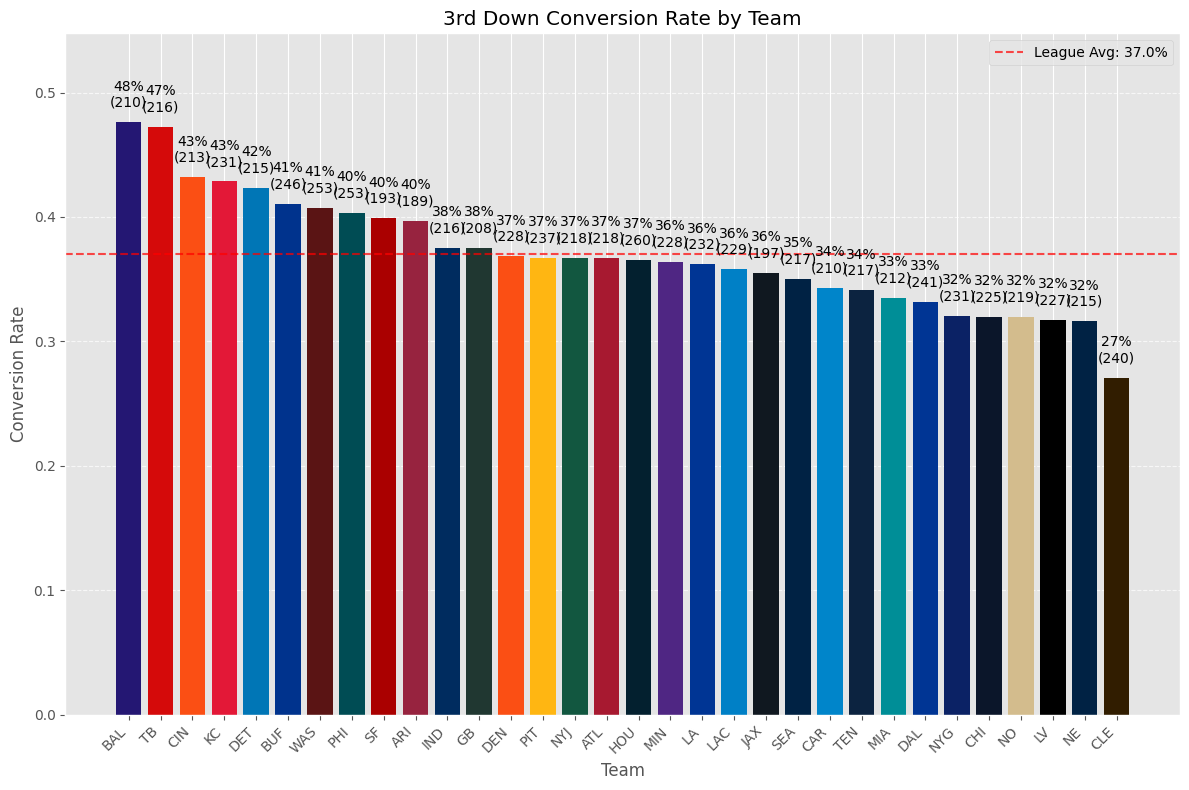

In [9]:

# Analyze 3rd down conversion rates by team
if all(col in df.columns for col in ['OffenseTeam', 'Down', 'SeriesFirstDown']):
    # Filter for 3rd downs
    third_down_df = df[
        (df['Down'] == 3) & 
        (df['PlayType'].isin(['PASS', 'RUSH', 'SACK']))
    ]
    
    # Calculate conversion rates
    conversion_rates = third_down_df.groupby('OffenseTeam').agg(
        conversion_rate=('SeriesFirstDown', lambda x: x.sum() / len(x) if len(x) > 0 else np.nan),
        attempts=('SeriesFirstDown', 'count')
    ).reset_index()
    
    # Sort by conversion rate
    conversion_rates = conversion_rates.sort_values('conversion_rate', ascending=False)
    
    # Plot conversion rates
    plt.figure(figsize=(12, 8))
    team_colors = get_team_colors()
    
    bars = plt.bar(
        conversion_rates['OffenseTeam'], 
        conversion_rates['conversion_rate'],
        color=[team_colors.get(team, ('#1f77b4', '#000000'))[0] for team in conversion_rates['OffenseTeam']]
    )
    
    # Add labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        attempts = conversion_rates.iloc[i]['attempts']
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.0%}\n({attempts})', ha='center', va='bottom')
    
    # Add league average line
    avg_rate = conversion_rates['conversion_rate'].mean()
    plt.axhline(avg_rate, color='r', linestyle='--', alpha=0.7, 
                label=f'League Avg: {avg_rate:.1%}')
    
    plt.title('3rd Down Conversion Rate by Team')
    plt.xlabel('Team')
    plt.ylabel('Conversion Rate')
    plt.ylim(0, max(conversion_rates['conversion_rate']) * 1.15)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# ## Red Zone Efficiency

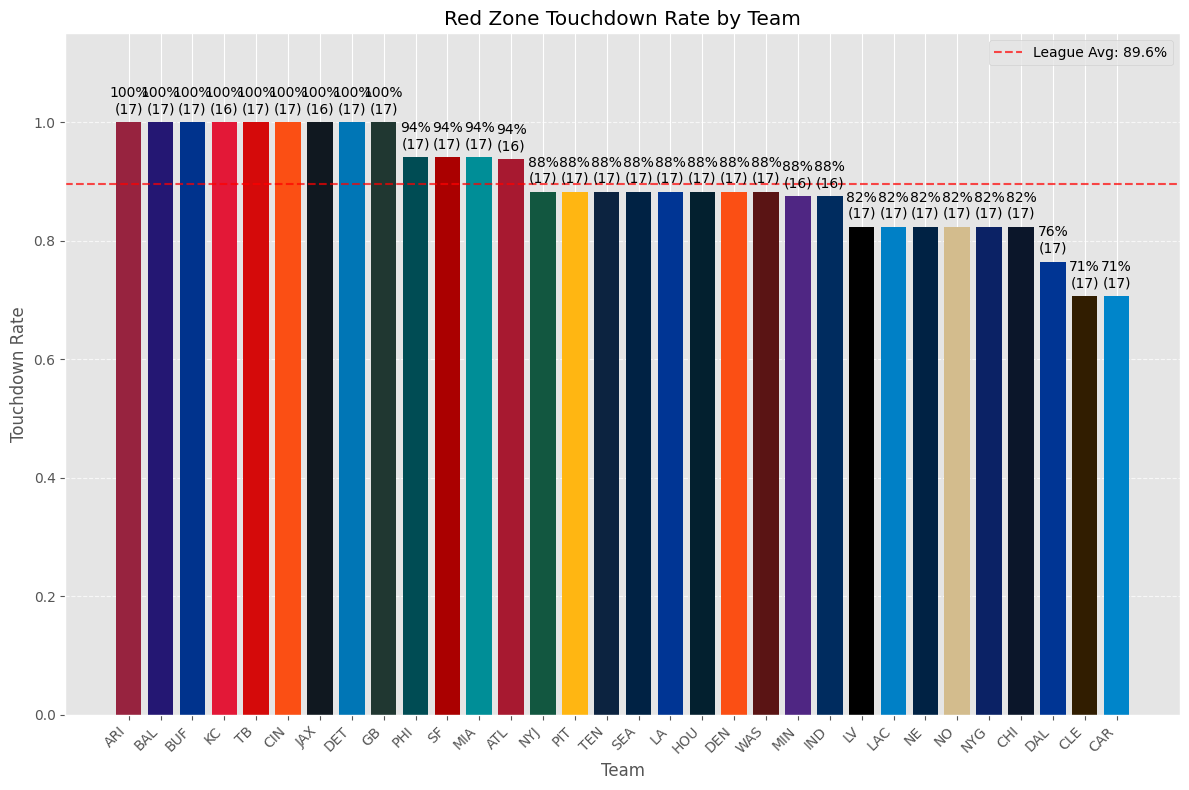

In [10]:

# Analyze red zone touchdown rates by team
if all(col in df.columns for col in ['OffenseTeam', 'is_redzone', 'IsTouchdown']):
    # Filter for red zone plays
    redzone_df = df[
        (df['is_redzone'] == True) & 
        (df['PlayType'].isin(['PASS', 'RUSH']))
    ]
    
    # Group by team and drive to identify unique red zone trips
    redzone_trips = redzone_df.groupby(['OffenseTeam', 'GameId']).agg(
        touchdowns=('IsTouchdown', 'sum'),
        plays=('IsTouchdown', 'count')
    ).reset_index()
    
    # A trip has a touchdown if there was at least one touchdown in the drive
    redzone_trips['has_touchdown'] = redzone_trips['touchdowns'] > 0
    
    # Calculate touchdown rates
    td_rates = redzone_trips.groupby('OffenseTeam').agg(
        td_rate=('has_touchdown', 'mean'),
        trips=('has_touchdown', 'count')
    ).reset_index()
    
    # Sort by touchdown rate
    td_rates = td_rates.sort_values('td_rate', ascending=False)
    
    # Plot touchdown rates
    plt.figure(figsize=(12, 8))
    
    bars = plt.bar(
        td_rates['OffenseTeam'], 
        td_rates['td_rate'],
        color=[team_colors.get(team, ('#1f77b4', '#000000'))[0] for team in td_rates['OffenseTeam']]
    )
    
    # Add labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        trips = td_rates.iloc[i]['trips']
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.0%}\n({trips})', ha='center', va='bottom')
    
    # Add league average line
    avg_rate = td_rates['td_rate'].mean()
    plt.axhline(avg_rate, color='r', linestyle='--', alpha=0.7, 
                label=f'League Avg: {avg_rate:.1%}')
    
    plt.title('Red Zone Touchdown Rate by Team')
    plt.xlabel('Team')
    plt.ylabel('Touchdown Rate')
    plt.ylim(0, max(td_rates['td_rate']) * 1.15)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# ## Team-Specific Play Calling

/Users/abdullah/Projects/nfl-pbp-analysis/notebooks/../scripts/visualizations.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_df['DistanceBin'] = pd.cut(
/Users/abdullah/Projects/nfl-pbp-analysis/notebooks/../scripts/visualizations.py:297: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = play_df.pivot_table(


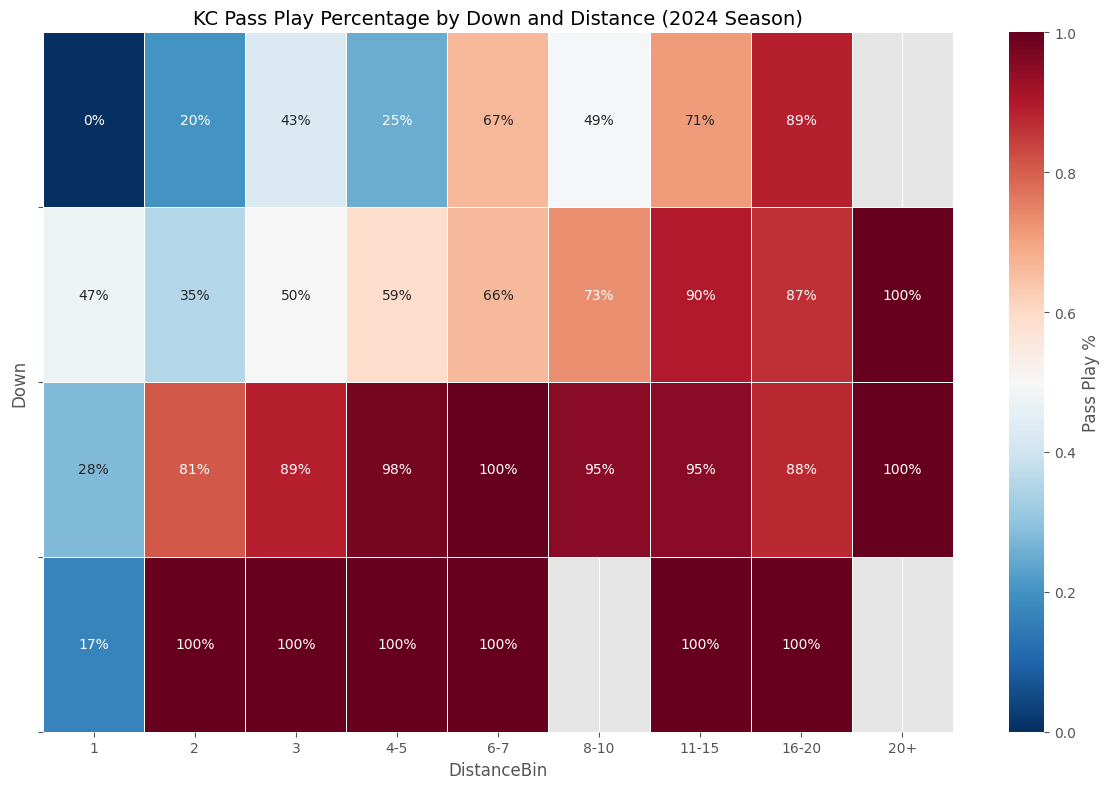

In [11]:

# Select a team for detailed analysis
team_to_analyze = 'KC'  # Change to any team abbreviation

# Display team-specific play calling heatmap
team_heatmap = plot_down_distance_heatmap(df, team=team_to_analyze)
plt.tight_layout()
plt.show()

/Users/abdullah/Projects/nfl-pbp-analysis/notebooks/../scripts/visualizations.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_df['DistanceBin'] = pd.cut(
/Users/abdullah/Projects/nfl-pbp-analysis/notebooks/../scripts/visualizations.py:297: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = play_df.pivot_table(


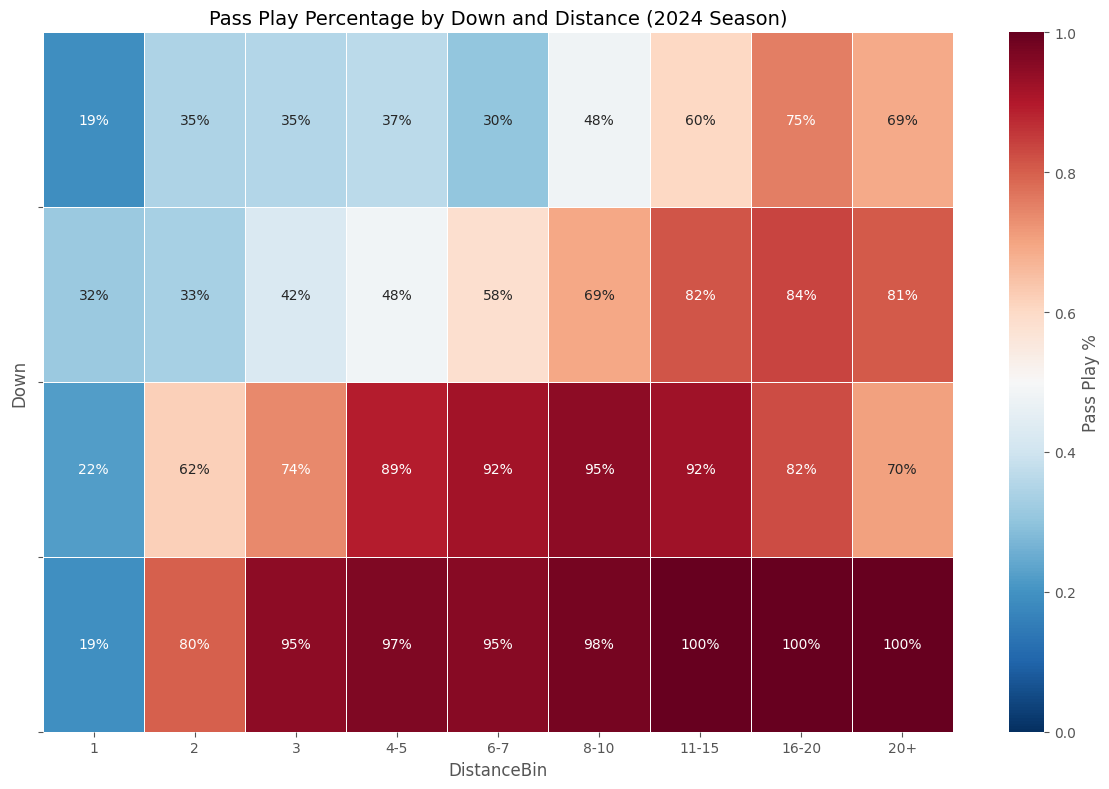

In [12]:

# Compare to league average
league_heatmap = plot_down_distance_heatmap(df)
plt.tight_layout()
plt.show()

# ## Summary of Team Tendencies

Team Offensive Tendencies Summary:
   OffenseTeam  play_count  pass_rate  rush_ypc  pass_ypa  \
31         WAS        1195       0.56      4.44      7.54   
25         PHI        1195       0.46      5.24      7.75   
3          BUF        1189       0.54      4.45      7.48   
16          LA        1143       0.58      4.35      7.34   
10         DET        1134       0.53      4.98      8.50   
2          BAL        1119       0.49      5.62      8.85   
15          KC        1118       0.61      3.82      6.94   
12         HOU        1108       0.60      4.34      7.32   
8          DAL        1090       0.62      4.13      6.60   
11          GB        1080       0.51      4.92      8.35   
29          TB        1070       0.58      5.12      8.00   
1          ATL        1070       0.55      4.87      7.94   
20         MIN        1061       0.59      4.15      7.91   
7          CLE        1054       0.66      4.05      6.47   
26         PIT        1047       0.53      4.07   

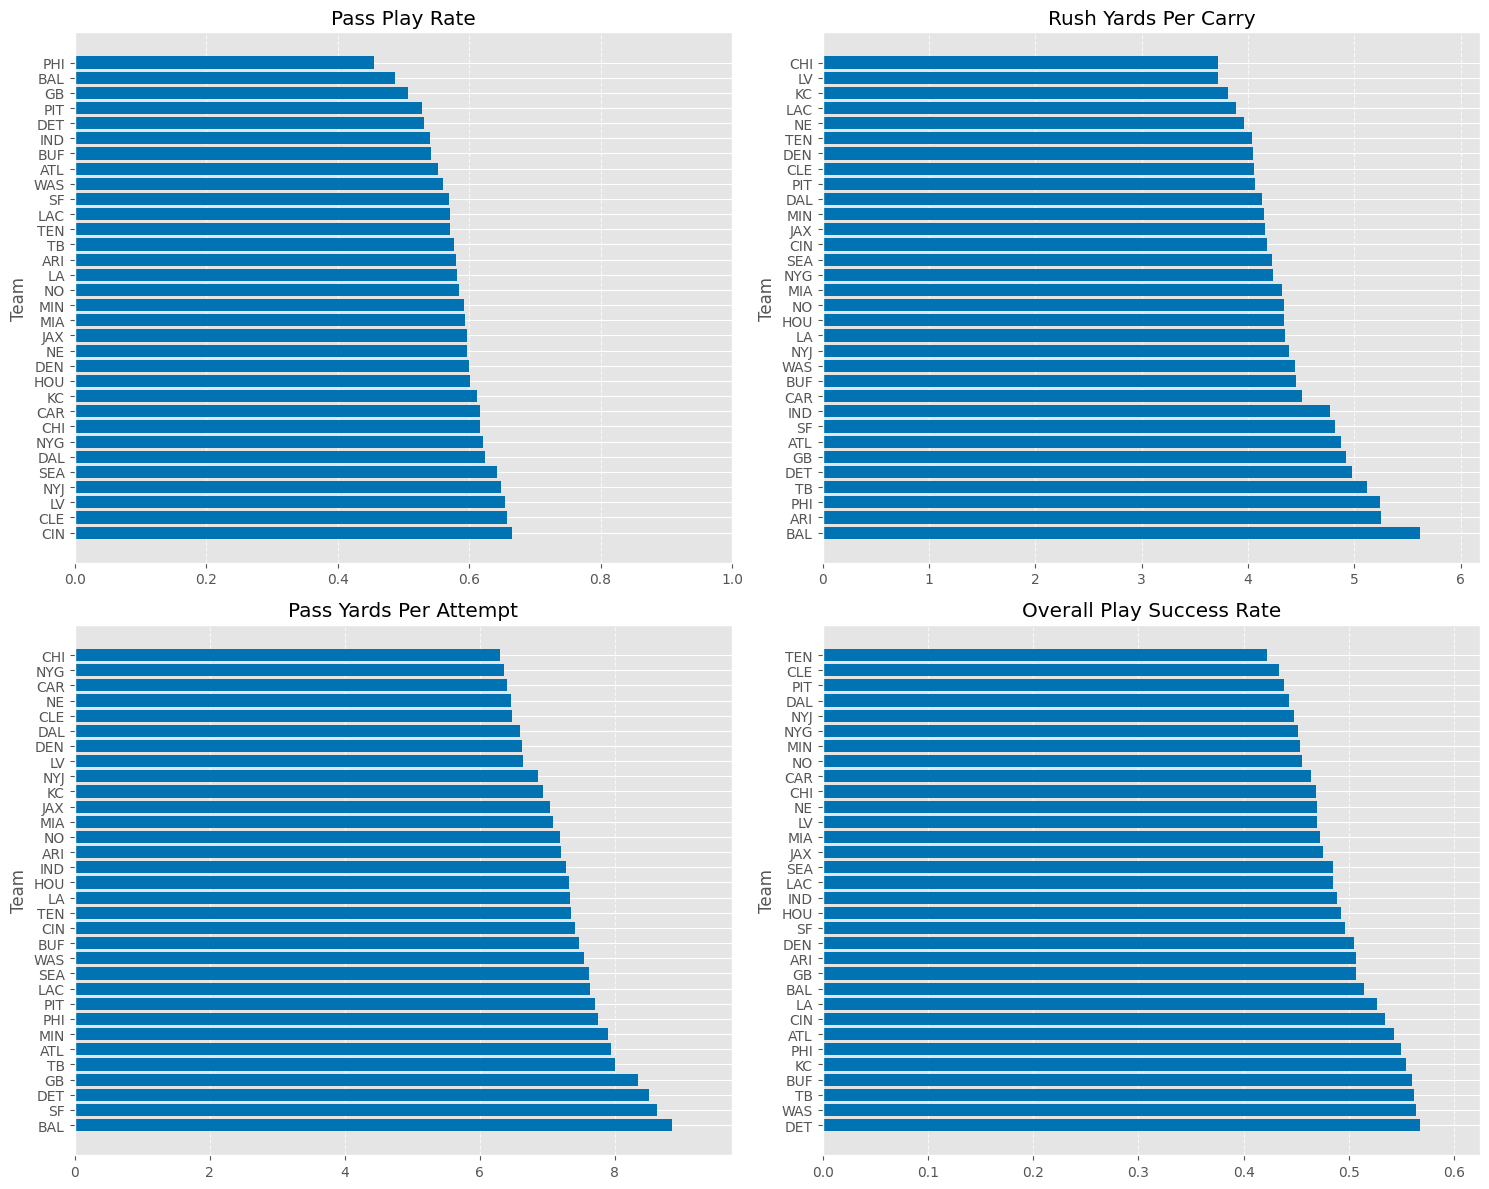

In [23]:

# Create a summary table of team tendencies
if all(col in df.columns for col in ['OffenseTeam', 'PlayType', 'Yards']):
    # Filter for standard plays
    play_df = df[
        (df['PlayType'].isin(['PASS', 'RUSH'])) & 
        (~pd.isna(df['Yards']))
    ]
    
    # Calculate team metrics
    # Calculate metrics separately
    play_counts = play_df.groupby('OffenseTeam')['PlayType'].count()
    pass_rates = play_df.groupby('OffenseTeam')['PlayType'].apply(lambda x: np.mean(x == 'PASS'))
    rush_ypc = play_df[play_df['PlayType'] == 'RUSH'].groupby('OffenseTeam')['Yards'].mean()
    pass_ypa = play_df[play_df['PlayType'] == 'PASS'].groupby('OffenseTeam')['Yards'].mean()
    
    # Combine into final dataframe
    team_metrics = pd.DataFrame({
        'play_count': play_counts,
        'pass_rate': pass_rates,
        'rush_ypc': rush_ypc,
        'pass_ypa': pass_ypa
    }).reset_index()
    
    # Add success rates if available
    success_df = team_success_rate(play_df)
    overall_success = success_df.groupby('OffenseTeam')['success_rate'].mean().reset_index()
    overall_success.columns = ['OffenseTeam', 'overall_success_rate']
    
    # Merge metrics
    team_metrics = pd.merge(team_metrics, overall_success, on='OffenseTeam', how='left')
    
    # Sort by play count
    team_metrics = team_metrics.sort_values('play_count', ascending=False)
    
    # Display table
    print("Team Offensive Tendencies Summary:")
    print(team_metrics.round({'pass_rate': 2, 'rush_ypc': 2, 'pass_ypa': 2, 'overall_success_rate': 2}))
    
    # Plot key metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Pass rate
    team_metrics = team_metrics.sort_values('pass_rate', ascending=False)
    axes[0, 0].barh(team_metrics['OffenseTeam'], team_metrics['pass_rate'])
    axes[0, 0].set_title('Pass Play Rate')
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylabel('Team')
    axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Rush yards per carry
    team_metrics = team_metrics.sort_values('rush_ypc', ascending=False)
    axes[0, 1].barh(team_metrics['OffenseTeam'], team_metrics['rush_ypc'])
    axes[0, 1].set_title('Rush Yards Per Carry')
    axes[0, 1].set_xlim(0, team_metrics['rush_ypc'].max() * 1.1)
    axes[0, 1].set_ylabel('Team')
    axes[0, 1].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Pass yards per attempt
    team_metrics = team_metrics.sort_values('pass_ypa', ascending=False)
    axes[1, 0].barh(team_metrics['OffenseTeam'], team_metrics['pass_ypa'])
    axes[1, 0].set_title('Pass Yards Per Attempt')
    axes[1, 0].set_xlim(0, team_metrics['pass_ypa'].max() * 1.1)
    axes[1, 0].set_ylabel('Team')
    axes[1, 0].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Overall success rate
    team_metrics = team_metrics.sort_values('overall_success_rate', ascending=False)
    axes[1, 1].barh(team_metrics['OffenseTeam'], team_metrics['overall_success_rate'])
    axes[1, 1].set_title('Overall Play Success Rate')
    axes[1, 1].set_xlim(0, team_metrics['overall_success_rate'].max() * 1.1)
    axes[1, 1].set_ylabel('Team')
    axes[1, 1].grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show() 